In [14]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from tqdm.notebook import tqdm
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kayle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def get_pages_links(url:str, lists:list = [])->list:#Метод извлекает все ссылки с начальной страницы
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    try:
        lists.append(url)
        next_page_link = "https://habr.com" + soup.find('a', id='pagination-next-page')["href"]
        get_pages_links(next_page_link, lists)
    except:
        pass
    return lists

def get_posts_links_by_page_url(page_url: str)-> list: #Метод выполняет обход всех публикаций по извлеченным ссылкам
    posts_links = []
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    for post_link in soup.find_all('a', class_='tm-title__link'):
        link = "https://habr.com" + post_link["href"]
        posts_links.append(link)
    return posts_links

def get_all_posts_links(company_url):#Метод извлекает все ссылки с постов
    pages_links = get_pages_links(company_url)
    linkes = []
    for link in pages_links:
        linkes.append(get_posts_links_by_page_url(link))
    flat_list = [item for sublist in linkes for item in sublist]
    return list(set(flat_list))

def get_profile_info(profile_url)->dict:
    response = requests.get(profile_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    categories = soup.findAll("a", class_ = "tm-company-profile__categories-text")
    category_list = []
    for category in categories:
        category_list.append(category.get_text())
        
    data = {
        "rating_company" : soup.find("span", class_ = "tm-votes-lever__score-counter").get_text(),
        "desc_company" : soup.find("div", class_ = "tm-company-card__description").get_text(),
        "category_list_company" : category_list,
        "about_company" : soup.find("span", class_ = "tm-company-profile__content").get_text()
    }
    return data

def get_company_post_info(post_url):
    response = requests.get(post_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tags_post = []
    tags = soup.findAll("a", class_ = "tm-article-snippet__hubs-item-link") 
    for tag in tags:
        tags_post.append(tag.get_text())
        
    labels_post = []
    labels = soup.findAll("div", class_ = "tm-article-snippet__label") 
    for label in labels:
        labels_post.append(label.get_text()) 
    tag = soup.find("span", class_="tm-article-complexity__label")
    if tag is not None:
        difficulty_post = tag.get_text()
    else:
        difficulty_post = "No label found"
    reading_time = soup.find("span", class_="tm-article-reading-time__label")
    if reading_time is not None:
        reading_time_post = re.findall(r'\d+', reading_time.get_text())[0]
    else:
        reading_time_post = "N/A"
        
    views_count = soup.find("span", class_="tm-icon-counter__value")
    if views_count is not None:
        views_count_post = re.findall(r'\d+\.\d+|\d+', views_count.get_text())[0]
    else:
        views_count_post = "N/A"
    data = {
        "name_post": soup.find("h1", class_ = "tm-title tm-title_h1").get_text(),
         "difficulty_post" : difficulty_post,
        "reading_time_post" : reading_time_post,
        "views_count_post" : views_count_post,
        "tags_post" : tags_post,
        "text_post" : soup.find("div", class_="tm-article-body").get_text()

    }
    return data

In [4]:
for i in tqdm(range(10000)):
    pass

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
companies_urls = [
    "https://habr.com/ru/companies/avito"
]
posts = []
for company_url in companies_urls:
    urls_posts = get_all_posts_links(company_url + "/blog/")
    profile_company = get_profile_info(company_url +"/profile/")
    
    for url in tqdm(urls_posts):
        post = get_company_post_info(url)
        post.update(profile_company)
        posts.append(post)

  0%|          | 0/260 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(posts)
df.head()

,name_post,difficulty_post,reading_time_post,views_count_post,tags_post,text_post,rating_company,desc_company,category_list_company,about_company
0,Введение в Puppet,No label found,26,71,[],Puppet — это система управления конфигурацией...,\n 155\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
1,Как мы нарисовали на карте несколько тысяч инт...,No label found,9,18,[],"Привет, меня зовут Дарья, и я Frontend-разраб...",\n 155\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
2,Как собрать свой Lighthouse,No label found,11,6,[],"Чем интенсивнее наш feature delivering, тем б...",\n 155\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
3,"Инфраструктура как код в Авито: уроки, которые...",No label found,19,11,[],"Привет, Хабр! Меня зовут Саша Козлов, я заним...",\n 155\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
4,Микрофронтенды в SSR: опыт Авито,No label found,8,7.2,[],"Привет! Меня зовут Дарья, и я разработчик в ю...",\n 155\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...


In [6]:
# Выполняем GET-запрос к веб-сайту
response = requests.get('https://habr.com/ru/companies/avito')

# Проверяем успешность запроса
if response.status_code == 200:
    # Сохраняем содержимое ответа в текстовый файлЫ
    with open('example.html', 'w', encoding='utf-8') as f:
        f.write(response.text)
        print('Данные сохранены в файл example.html')
else:
    print('Ошибка при выполнении запроса:', response.status_code)

Данные сохранены в файл example.html


In [7]:
df.columns

Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company'],
      dtype='object')

In [8]:
unique_names = df["name_post"].unique()
unique_names

array(['Введение в Puppet',
       'Как мы нарисовали на карте несколько тысяч интерактивных объектов без вреда для перформанса',
       'Как собрать свой Lighthouse',
       'Инфраструктура как код в Авито: уроки, которые мы извлекли',
       'Микрофронтенды в SSR: опыт Авито',
       'Система Quality Score: как оценивать внешнее качество продукта',
       'Как мы закрыли все объявления частных пользователей защитными номерами',
       'DWH как продукт: платформа, инструменты, масштабирование команды',
       'На чем писать Android UI-тесты',
       'Как я сделал дизайн для Брендспейса Авито за две недели, а потом дважды его переделывал',
       'Netramesh – легковесное service mesh решение',
       'Прямой эфир: как обуздать iOS-разработку в больших командах',
       'Архивная репликация в PostgreSQL: пошаговая инструкция',
       'На что обращать внимание на алгоритмических секциях собеседований',
       'Мутационное тестирование: опыт внедрения на 1500 сервисов',
       'Материалы 

In [9]:
len(unique_names)

259

In [10]:
df.to_csv("init_dataset.csv", index=False)

In [11]:
NOMINATIONS = [
    "Государство и Общество",
    "Культурные проекты в сети",
    "Народов много - Родина одна",
    "Образование и Кадры",
    "Наука, технологии и инновации",
    "Туризм и индустрия гостеприимства",
    "Экономика и Бизнес",
    "Здоровье и медицина",
    "Туризм и индустрия гостеприимства",
    "Подкасты и цифровой контент"
    ]

In [12]:
df_explore = df[['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'text_post', 'rating_company',
       'desc_company', 'about_company']]

Shape of the DataFrame: (260, 10)
Columns in the DataFrame: Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company'],
      dtype='object')
Data types of the columns:
 name_post                object
difficulty_post          object
reading_time_post        object
views_count_post         object
tags_post                object
text_post                object
rating_company           object
desc_company             object
category_list_company    object
about_company            object
dtype: object
Summary statistics of the DataFrame:
                                      name_post difficulty_post   
count                                      260             260  \
unique                                     259               3   
top     Академия Аналитиков Авито: новый набор  No label found   
freq                                         2           

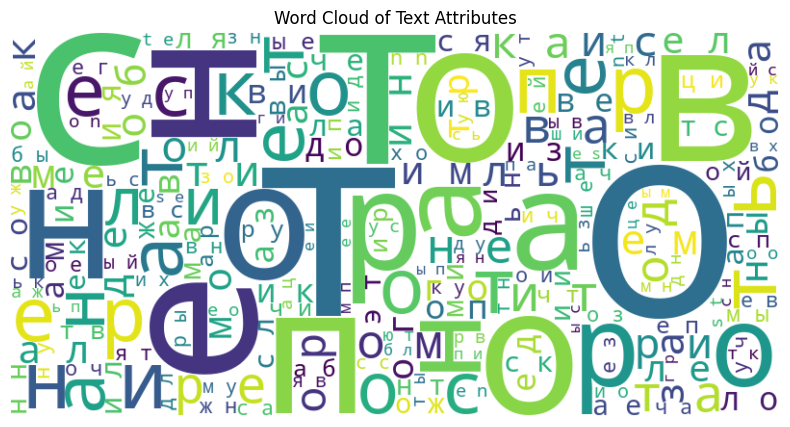

In [15]:
# Исследование базовых данных
print("Shape of the DataFrame:", df.shape)  # Получиаем количество строк и столбцов
print("Columns in the DataFrame:", df.columns)  # Получиаем имена столбцов
print("Data types of the columns:\n", df.dtypes)  # Получаем типы данных столбцов
print("Summary statistics of the DataFrame:\n", df.describe())  # Получаем сводную статистику

# Исследуем текстовые данные
# Выполняем задачи поиска текстовых данных, такие как подсчет слов, количество уникальных слов и т.д.
# Количество слов
df['word_count'] = df['text_post'].apply(lambda x: len(str(x).split()))
print("Word count statistics:\n", df['word_count'].describe())

# Количество уникальных слов
df['unique_word_count'] = df['text_post'].apply(lambda x: len(set(str(x).split())))
print("Unique word count statistics:\n", df['unique_word_count'].describe())

# Количество стоп-слов
stopwords_list = set(stopwords.words('russian'))  # Update with appropriate language
df['stopword_count'] = df['text_post'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords_list]))
print("Stopword count statistics:\n", df['stopword_count'].describe())

# Визуализация данных
# Используя различные библиотеки построения графиков, такие как Matplotlib и WordCloud, для визуализации текстовых данных
# Примеры графиков:
# Облако слов
text = ' '.join(str(df['text_post'].values))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Attributes')
plt.show()

In [16]:
df.isna().sum()

name_post                0
difficulty_post          0
reading_time_post        0
views_count_post         0
tags_post                0
text_post                0
rating_company           0
desc_company             0
category_list_company    0
about_company            0
word_count               0
unique_word_count        0
stopword_count           0
dtype: int64